In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.0/899.0 kB 17.8 MB/s eta 0:00:00


In [2]:
import os
import json
import shutil
import random
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO
import seaborn as sns
from sklearn.metrics import confusion_matrix

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Paths
root_dir = "/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr"  # Root directory
output_dir = "/kaggle/working/"  # Final output directory
annotations_folder = "annotations"  # Folder with JSON files

# Train-val-test split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Mapping classes to IDs for YOLO format
class_mapping = {
    "Araneae": 0,
    "Coleoptera": 1,
    "Diptera": 2,
    "Hemiptera": 3,
    "Hymenoptera": 4,
    "Lepidoptera": 5,
    "Odonata": 6
}

# Function to create YOLOv8 format from JSON
def convert_json_to_yolo(json_file, image_file, save_dir, class_id):
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Image width and height
    image_width = data['asset']['size']['width']
    image_height = data['asset']['size']['height']

    # Extract bounding boxes
    yolo_lines = []
    for region in data.get('regions', []):
        bbox = region['boundingBox']
        x_center = (bbox['left'] + bbox['width'] / 2) / image_width
        y_center = (bbox['top'] + bbox['height'] / 2) / image_height
        width = bbox['width'] / image_width
        height = bbox['height'] / image_height

        yolo_lines.append(f"{class_id} {x_center} {y_center} {width} {height}\n")

    # Save YOLO annotation
    label_path = os.path.join(save_dir, 'labels')
    os.makedirs(label_path, exist_ok=True)
    base_name = os.path.splitext(os.path.basename(image_file))[0]
    with open(os.path.join(label_path, f"{base_name}.txt"), 'w') as f:
        f.writelines(yolo_lines)

    # Copy image to save_dir
    image_path = os.path.join(save_dir, 'images')
    os.makedirs(image_path, exist_ok=True)
    shutil.copy(image_file, os.path.join(image_path, os.path.basename(image_file)))


# Function to process the entire dataset
def process_dataset(root_dir, output_dir, split_ratios, class_mapping):
    all_data = []

    # Traverse through each class folder
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            annotations_path = os.path.join(class_path, annotations_folder)
            if not os.path.exists(annotations_path):
                continue

            # Process each JSON file
            for json_file in os.listdir(annotations_path):
                if json_file.endswith(".json"):
                    json_path = os.path.join(annotations_path, json_file)

                    # Find corresponding image file (assuming same structure)
                    with open(json_path, 'r') as f:
                        data = json.load(f)
                        image_name = data['asset']['name']
                        image_path = os.path.join(class_path, image_name)
                        if os.path.exists(image_path):
                            all_data.append((image_path, json_path, class_mapping[class_name]))

    # Split data into train, val, and test
    train_data, temp_data = train_test_split(all_data, train_size=split_ratios[0], random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=split_ratios[2] / (split_ratios[1] + split_ratios[2]), random_state=42)

    # Process each split
    for split_name, split_data in zip(['train', 'val', 'test'], [train_data, val_data, test_data]):
        split_dir = os.path.join(output_dir, split_name)
        for image_path, json_path, class_id in split_data:
            convert_json_to_yolo(json_path, image_path, split_dir, class_id)
    print("Dataset successfully converted to YOLO format.")

# Function to create data.yaml
def create_data_yaml(output_dir, class_mapping):
    yaml_content = f"""train: {os.path.join(output_dir, 'train/images')}
val: {os.path.join(output_dir, 'val/images')}
test: {os.path.join(output_dir, 'test/images')}

nc: {len(class_mapping)}
names: {list(class_mapping.keys())}"""
    with open(os.path.join(output_dir, "data.yaml"), "w") as f:
        f.write(yaml_content)
    print("data.yaml created.")

In [4]:
# Main Execution
if __name__ == "__main__":

    # Process dataset
    split_ratios = (train_ratio, val_ratio, test_ratio)
    process_dataset(root_dir, output_dir, split_ratios, class_mapping)

    # Create data.yaml
    create_data_yaml(output_dir, class_mapping)
    print("All tasks completed successfully!")

Dataset successfully converted to YOLO format.
data.yaml created.
All tasks completed successfully!


In [5]:
train_images_path = '/kaggle/working/train/images/'
train_labels_path = '/kaggle/working/train/labels/'

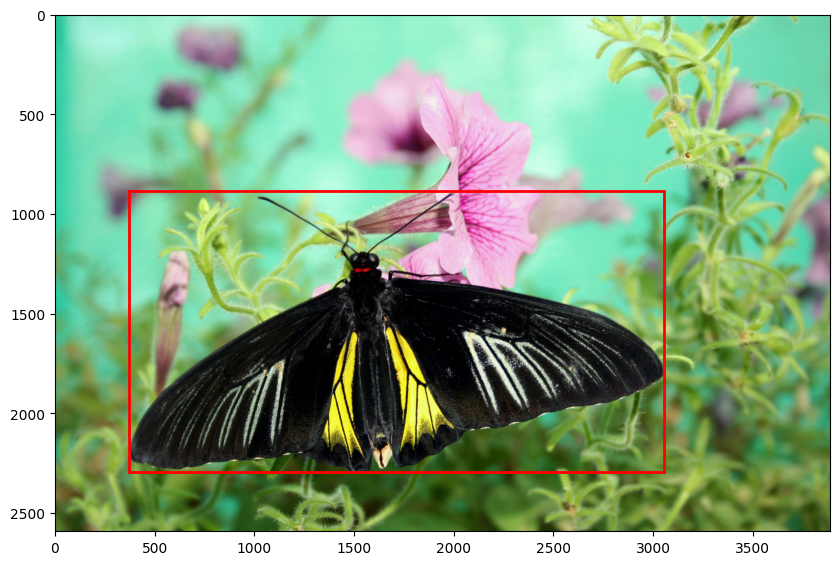

In [6]:
# Load an image and its corresponding label
image_name = '00026d79d067.jpg' 
image_path = os.path.join(train_images_path, image_name)
label_path = os.path.join(train_labels_path, image_name.replace('.jpg', '.txt'))  # Assuming label file is .txt

# Read the image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Initialize the figure for plotting
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(image_rgb)

# Read the label file
with open(label_path, 'r') as file:
    lines = file.readlines()

# Loop through each line in the label file and draw the corresponding bounding box
for line in lines:
    # Parse the label
    parts = line.strip().split()
    class_id = int(parts[0])
    x_center = float(parts[1]) * image.shape[1]  # Convert from relative to absolute coordinates
    y_center = float(parts[2]) * image.shape[0]
    width = float(parts[3]) * image.shape[1]
    height = float(parts[4]) * image.shape[0]
    
    # Convert center coordinates to top-left corner coordinates
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    
    # Draw the rectangle (bounding box)
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Show the plot with bounding boxes
plt.show()


In [7]:
!nvidia-smi

Mon Dec 16 15:32:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 81.8MB/s]


In [9]:
model.train(data='/kaggle/working/data.yaml', epochs=10, batch=32, imgsz=640)

Ultralytics 8.3.50 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

100%|██████████| 755k/755k [00:00<00:00, 17.4MB/s]


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.1MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/train/labels... 10761 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10761/10761 [00:12<00:00, 860.71it/s]


train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/val/labels... 3075 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3075/3075 [00:03<00:00, 973.37it/s]


val: New cache created: /kaggle/working/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.63G      1.194      3.407      1.533          9        640: 100%|██████████| 337/337 [04:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:02<00:00,  1.27s/it]


                   all       3075       3824      0.348      0.439      0.322      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.52G      1.181      2.259      1.481         15        640: 100%|██████████| 337/337 [04:19<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:03<00:00,  1.29s/it]

                   all       3075       3824      0.465      0.479      0.451      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.66G      1.157      1.868      1.442          9        640: 100%|██████████| 337/337 [04:10<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:02<00:00,  1.27s/it]


                   all       3075       3824      0.473      0.502      0.461      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.38G      1.132      1.703      1.422          9        640: 100%|██████████| 337/337 [04:05<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:00<00:00,  1.24s/it]

                   all       3075       3824      0.541       0.52      0.513      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.62G      1.039      1.512      1.351         31        640: 100%|██████████| 337/337 [04:05<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:00<00:00,  1.23s/it]


                   all       3075       3824      0.569      0.516      0.556      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.51G     0.9718      1.362      1.299         13        640: 100%|██████████| 337/337 [04:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:00<00:00,  1.23s/it]

                   all       3075       3824       0.65      0.602      0.636      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.57G     0.9141      1.234      1.253         14        640: 100%|██████████| 337/337 [04:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:01<00:00,  1.26s/it]

                   all       3075       3824      0.698      0.633      0.692      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.59G     0.8496       1.12      1.208         11        640: 100%|██████████| 337/337 [04:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:01<00:00,  1.25s/it]

                   all       3075       3824      0.726      0.656       0.72      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.55G     0.8126      1.017      1.175          9        640: 100%|██████████| 337/337 [04:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:01<00:00,  1.25s/it]

                   all       3075       3824      0.751      0.668      0.733      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.44G     0.7764     0.9403      1.151         13        640: 100%|██████████| 337/337 [04:13<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:00<00:00,  1.23s/it]

                   all       3075       3824      0.784      0.697      0.768      0.629



10 epochs completed in 0.867 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.50 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:01<00:00,  1.25s/it]


                   all       3075       3824      0.784      0.697      0.768      0.629
               Araneae        473        505      0.905      0.738      0.849      0.694
            Coleoptera        415        526      0.734      0.687      0.742      0.598
               Diptera        394        465      0.707      0.673      0.729      0.612
             Hemiptera        509        629      0.816      0.656      0.777      0.658
           Hymenoptera        395        576       0.63      0.503      0.579      0.445
           Lepidoptera        448        649      0.771      0.695      0.752      0.569
               Odonata        441        474      0.928      0.925      0.951      0.826
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e331d59ec50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

In [ ]:
results = model.val()

In [ ]:
model.save('/kaggle/working/model.pt') 